In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels as sm
import math
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize, confint_proportions_2indep, power_proportions_2indep
from statsmodels.stats.power import NormalIndPower
import numpy as np
import statsmodels.stats.api as sms

In [2]:
def simulate_hiring_outcomes(num_men, num_women,
                                men_qualified_rate, women_qualified_rate,
                                qualified_men_hiring_rate, qualified_women_hiring_rate,
                                unqualified_men_hiring_rate, unqualified_women_hiring_rate):
    """
    Simulate the hiring outcomes for a population of men and women.

    Parameters:
    - num_men: Number of men in the population
    - num_women: Number of women in the population
    - men_qualified_rate: Proportion of men who are actually qualified
    - women_qualified_rate: Proportion of women who are actually qualified
    - qualified_men_hiring_rate: Proportion of qualified men who are hired
    - qualified_women_hiring_rate: Proportion of qualified women who are hired
    - unqualified_men_hiring_rate: Proportion of unqualified men who are hired
    - unqualified_women_hiring_rate: Proportion of unqualified women who are hired

    Returns:
    - DataFrame containing the group label, prediction (hiring decision), and true label (qualification) for each individual
    """

    # Generate true labels for qualification
    men_labels = np.random.choice([1, 0], size=num_men, p=[men_qualified_rate, 1-men_qualified_rate])
    women_labels = np.random.choice([1, 0], size=num_women, p=[women_qualified_rate, 1-women_qualified_rate])

    # Initialize predictions with 0 (not hired)
    men_predictions = np.zeros(num_men)
    women_predictions = np.zeros(num_women)

    # Get indices of qualified and unqualified men and women
    qualified_men_indices = np.where(men_labels == 1)[0]
    qualified_women_indices = np.where(women_labels == 1)[0]

    unqualified_men_indices = np.where(men_labels == 0)[0]
    unqualified_women_indices = np.where(women_labels == 0)[0]

    # Hire qualified men and women based on specified hiring rates
    num_qualified_men_hired = int(len(qualified_men_indices) * qualified_men_hiring_rate)
    num_qualified_women_hired = int(len(qualified_women_indices) * qualified_women_hiring_rate)

    men_predictions[np.random.choice(qualified_men_indices, num_qualified_men_hired, replace=False)] = 1
    women_predictions[np.random.choice(qualified_women_indices, num_qualified_women_hired, replace=False)] = 1

    # Hire unqualified men and women based on specified hiring rates
    num_unqualified_men_hired = int(len(unqualified_men_indices) * unqualified_men_hiring_rate)
    num_unqualified_women_hired = int(len(unqualified_women_indices) * unqualified_women_hiring_rate)

    men_predictions[np.random.choice(unqualified_men_indices, num_unqualified_men_hired, replace=False)] = 1
    women_predictions[np.random.choice(unqualified_women_indices, num_unqualified_women_hired, replace=False)] = 1

    # Create DataFrame
    data = {
        'group': ['men'] * num_men + ['women'] * num_women,
        'true_label': np.concatenate([men_labels, women_labels]),
        'prediction': np.concatenate([men_predictions, women_predictions])
    }

    return pd.DataFrame(data)

def plot_hiring_outcomes(df):
    # Define labels for the pie charts
    labels = ['Hired', 'Not Hired']
    alpha = 0.7

    # Filter the DataFrame for each group and outcome
    qualified_men = df[(df['group'] == 'men') & (df['true_label'] == 1)]
    qualified_women = df[(df['group'] == 'women') & (df['true_label'] == 1)]
    unqualified_men = df[(df['group'] == 'men') & (df['true_label'] == 0)]
    unqualified_women = df[(df['group'] == 'women') & (df['true_label'] == 0)]

    # Get the counts for the pie charts, ensuring both 'Hired' and 'Not Hired' categories are present
    q_men_counts = qualified_men['prediction'].value_counts().reindex([1, 0], fill_value=0).values
    q_women_counts = qualified_women['prediction'].value_counts().reindex([1, 0], fill_value=0).values
    uq_men_counts = unqualified_men['prediction'].value_counts().reindex([1, 0], fill_value=0).values
    uq_women_counts = unqualified_women['prediction'].value_counts().reindex([1, 0], fill_value=0).values

    # Create a figure with four subplots (2x2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Plot pie chart for qualified men
    axes[0, 0].pie(q_men_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'], wedgeprops={"alpha": alpha})
    axes[0, 0].set_title('Qualified Men', fontweight='bold')

    # Plot pie chart for qualified women
    axes[0, 1].pie(q_women_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'], wedgeprops={"alpha": alpha})
    axes[0, 1].set_title('Qualified Women', fontweight='bold')

    # Plot pie chart for unqualified men
    axes[1, 0].pie(uq_men_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgray'], wedgeprops={"alpha": alpha})
    axes[1, 0].set_title('Unqualified Men', fontweight='bold')

    # Plot pie chart for unqualified women
    axes[1, 1].pie(uq_women_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgray'], wedgeprops={"alpha": alpha})
    axes[1, 1].set_title('Unqualified Women', fontweight='bold')

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

def plot_sample_selection_rates(sample_metrics, pop_men_sel_rate, pop_women_sel_rate):
  # Convert sample_metrics to a DataFrame

  # Creating the histogram for both 'men_sel_rate' and 'women_sel_rate'
  plt.figure(figsize=(8, 6))

  # Histogram for men
  plt.hist(sample_metrics['men_selection_rate'], bins=20, alpha=0.5, edgecolor='black', label='Men Selection Rate')

  # Histogram for women
  plt.hist(sample_metrics['women_selection_rate'], bins=20, alpha=0.5, edgecolor='black', label='Women Selection Rate')

  # Add a vertical line at the population mean for men
  plt.axvline(pop_men_sel_rate, color='blue', linestyle='dashed', linewidth=2, label=f"Men Population Rate: {pop_men_sel_rate:.2f}")

  # Add a vertical line at the population mean for women
  plt.axvline(pop_women_sel_rate, color='orange', linestyle='dashed', linewidth=2, label=f"Women Population Rate: {pop_women_sel_rate:.2f}")


  # Adding labels and title
  plt.xlabel('Selection Rate')
  plt.ylabel('Frequency')
  plt.title('Histogram of Selection Rates for Men and Women')
  plt.legend()

  # Display the histogram
  plt.show()

def plot_p_values(sample_stats, metric_name='sel_rate_thresh'):

  p_vals = [sample['p'] for sample in audit_stats]

  print(f"Number of significant p-vals for {metric_name}: {len([p for p in p_vals if p < 0.05])}. Number of non-significant p-vals for {metric_name}: {len([p for p in p_vals if p >= 0.05])}")

  # Creating the histogram for p values for simulated samples
  plt.figure(figsize=(8, 6))
  plt.hist(p_vals, bins=20, edgecolor='black')
  # Add a vertical line at the population mean
  plt.axvline(0.05, color='red', linestyle='dashed', linewidth=2, label=f'significance: p<0.05')


  # Adding labels and title
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.title(f'Histogram of P Values for Hypothesis Test on {metric_name}')
  plt.legend()

  # Display the histogram
  plt.show()

def calculate_metrics(df):
    """
    Calculate the tp, tn, fp, fn, and overall selection rate for men and women.

    Parameters:
    - df: DataFrame containing the group label, prediction (hiring decision), and true label (qualification)

    Returns:
    - Flat dictionary containing the metrics for men and women
    """

    metrics = {}

    # Calculate metrics for men
    men_df = df[df['group'] == 'men']

    metrics['men_tp'] = len(men_df[(men_df['prediction'] == 1) & (men_df['true_label'] == 1)])
    metrics['men_tn'] = len(men_df[(men_df['prediction'] == 0) & (men_df['true_label'] == 0)])
    metrics['men_fp'] = len(men_df[(men_df['prediction'] == 1) & (men_df['true_label'] == 0)])
    metrics['men_fn'] = len(men_df[(men_df['prediction'] == 0) & (men_df['true_label'] == 1)])
    metrics['men_selection_rate'] = len(men_df[men_df['prediction'] == 1]) / len(men_df)

    # Calculate metrics for women
    women_df = df[df['group'] == 'women']

    metrics['women_tp'] = len(women_df[(women_df['prediction'] == 1) & (women_df['true_label'] == 1)])
    metrics['women_tn'] = len(women_df[(women_df['prediction'] == 0) & (women_df['true_label'] == 0)])
    metrics['women_fp'] = len(women_df[(women_df['prediction'] == 1) & (women_df['true_label'] == 0)])
    metrics['women_fn'] = len(women_df[(women_df['prediction'] == 0) & (women_df['true_label'] == 1)])
    metrics['women_selection_rate'] = len(women_df[women_df['prediction'] == 1]) / len(women_df)

    metrics['difference_selection_rate']=metrics['men_selection_rate']-metrics['women_selection_rate']

    return metrics

def simulate_audit(df, men_sample_size, women_sample_size, n_iterations=1, sel_rate_thresh=0.05):
    """
    Simulate an audit by sampling a specified number of men and women from the population,
    and calculate the tp, tn, fp, fn, and overall selection rate for the sample.
    Perform this process multiple times and aggregate the results into a DataFrame.

    Parameters:
    - df: DataFrame containing the group label, prediction (hiring decision), and true label (qualification)
    - men_sample_size: Number of men to sample
    - women_sample_size: Number of women to sample
    - n_iterations: Number of times to repeat the sampling and metrics calculation

    Returns:
    - DataFrame containing the aggregated metrics for each iteration
    """

    # List to hold metrics for each iteration
    metrics= []
    stats = []

    for _ in range(n_iterations):
        # Sample the specified number of men and women
        men_sample = df[df['group'] == 'men'].sample(n=men_sample_size, replace=False)
        women_sample = df[df['group'] == 'women'].sample(n=women_sample_size, replace=False)

        # Combine the sampled men and women into a single DataFrame
        sample_df = pd.concat([men_sample, women_sample])

        # Calculate metrics for the sample using the calculate_metrics function
        sample_metrics = calculate_metrics(sample_df)

        # Append the metrics to the list
        metrics.append(sample_metrics)
        # Perform the two-sample z-test for proportions
        # for one sided, we are testing H0: men_sel_rate - women_sel_rate <= proportion_diff, H1: men_sel_rate - women_sel_rate > proportion_diff
        #one sided test
        men_success = sample_metrics["men_tp"]+sample_metrics["men_fp"]
        women_success =  sample_metrics["women_tp"]+sample_metrics["women_fp"]
        stat, p_value = proportions_ztest([men_success, women_success], [men_sample_size, women_sample_size], value=sel_rate_thresh, alternative='larger')
        stats.append({"sample_num": n_iterations, "z_stat": stat, 'p': p_value})

    # Convert the list of dictionaries to a DataFrame
    metrics_df = pd.DataFrame(metrics)

    return metrics_df, stats


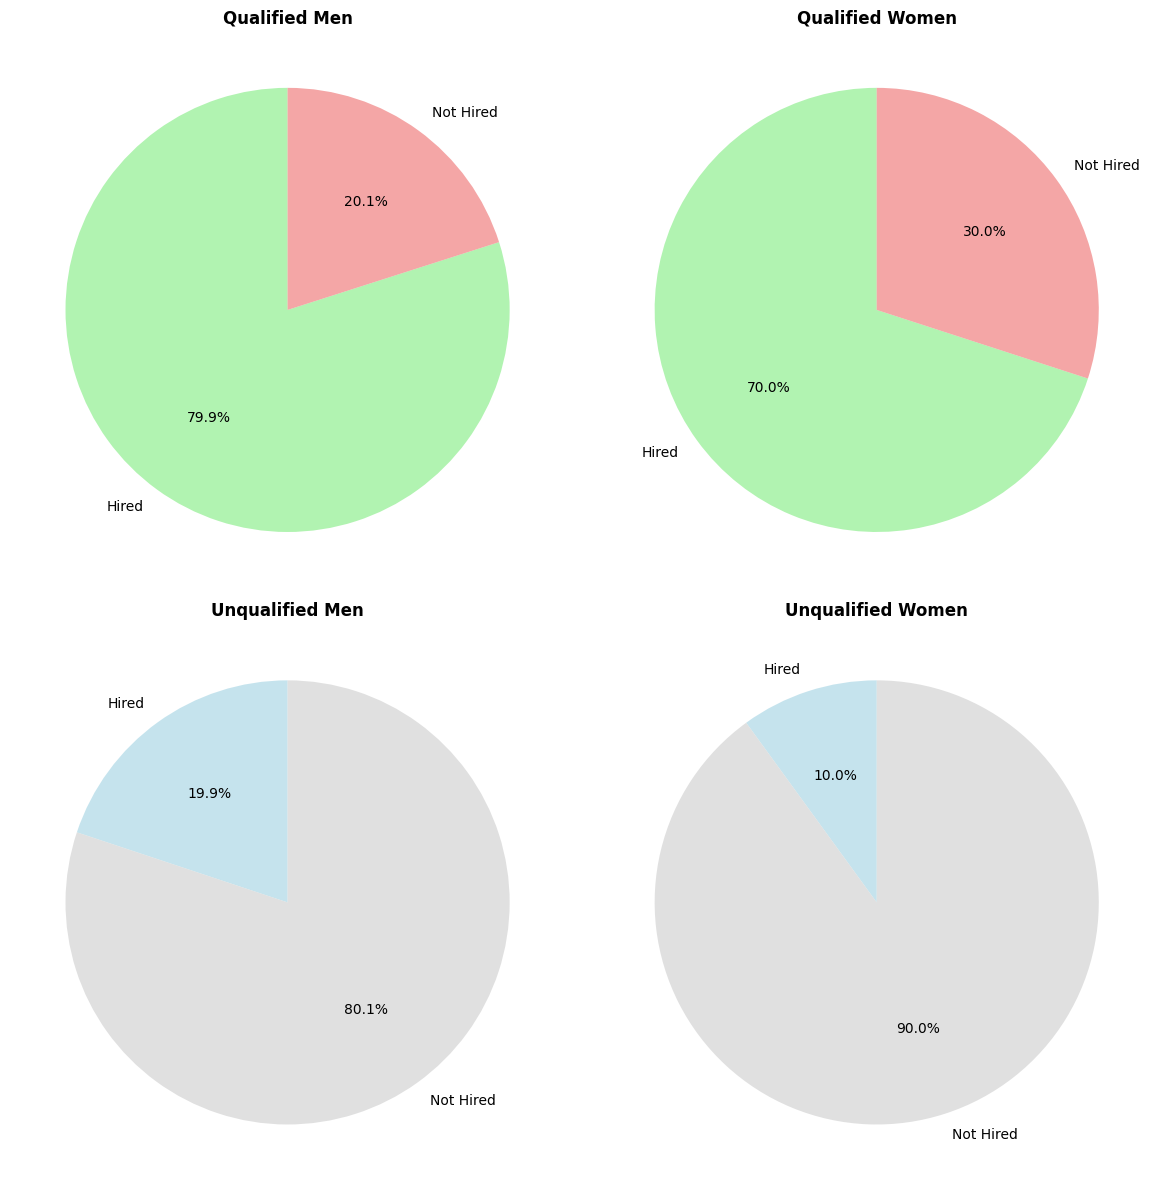

{'men_tp': 255, 'men_tn': 145, 'men_fp': 36, 'men_fn': 64, 'men_selection_rate': 0.582, 'women_tp': 210, 'women_tn': 180, 'women_fp': 20, 'women_fn': 90, 'women_selection_rate': 0.46, 'difference_selection_rate': 0.12199999999999994}


In [3]:
bias_population= simulate_hiring_outcomes(
    num_men=500,
    num_women=500,
    men_qualified_rate=0.6,  # 70% of men are actually qualified
    women_qualified_rate=0.6,  # 60% of women are actually qualified
    qualified_men_hiring_rate=0.8,  # 80% of qualified men are hired
    qualified_women_hiring_rate=0.7,  # 75% of qualified women are hired
    unqualified_men_hiring_rate=0.2,  # 20% of unqualified men are hired
    unqualified_women_hiring_rate=0.1  # 10% of unqualified women are hired
)

plot_hiring_outcomes(bias_population)
bias_population_metrics = calculate_metrics(bias_population)
print(bias_population_metrics)

In [4]:
# Simulate an audit with a sample of 100 men and 100 women, repeated 10 times
audit_metrics_df, audit_stats = simulate_audit(bias_population, men_sample_size=100, women_sample_size=100, n_iterations=100)


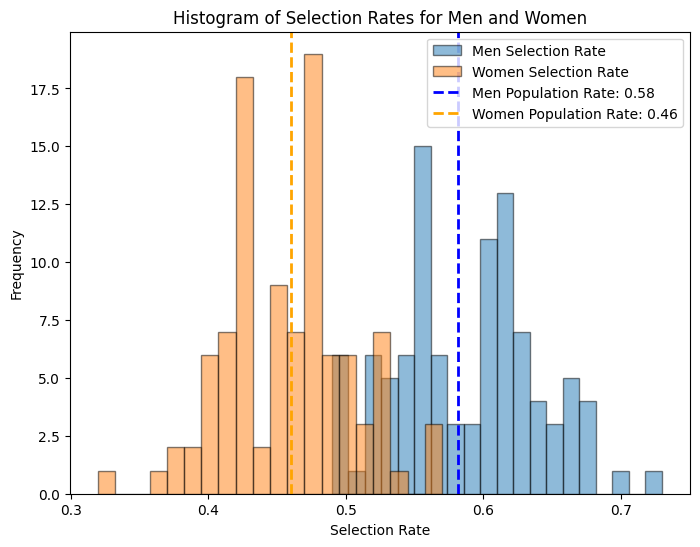

In [5]:
plot_sample_selection_rates(audit_metrics_df, pop_men_sel_rate=bias_population_metrics['men_selection_rate'],pop_women_sel_rate=bias_population_metrics['women_selection_rate'])

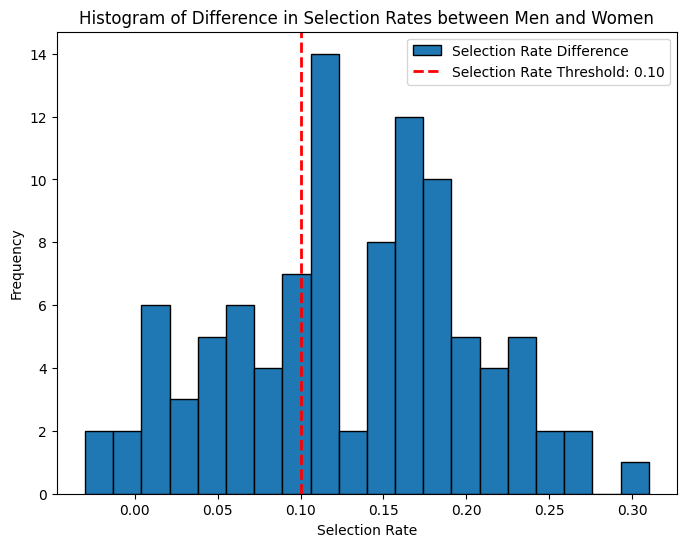

Number of samples with a difference greater than or equal to the threshold of 0.1: 67


In [6]:
sel_rate_thresh = 0.1

sel_rate_diff = audit_metrics_df['men_selection_rate']-audit_metrics_df['women_selection_rate'].to_list()

# Creating the histogram for both 'men_sel_rate' and 'women_sel_rate'
plt.figure(figsize=(8, 6))

# Histogram for men
plt.hist(sel_rate_diff, bins=20, alpha=1, edgecolor='black', label='Selection Rate Difference')


# Add a vertical line at the population mean for men
plt.axvline(sel_rate_thresh, color='red', linestyle='dashed', linewidth=2, label=f"Selection Rate Threshold: {sel_rate_thresh:.2f}")


# Adding labels and title
plt.xlabel('Selection Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Difference in Selection Rates between Men and Women')
plt.legend()

# Display the histogram
plt.show()

print(f"Number of samples with a difference greater than or equal to the threshold of {sel_rate_thresh}: {len([val for val in sel_rate_diff if val >= sel_rate_thresh])}")


Number of significant p-vals for sel_rate_thresh: 36. Number of non-significant p-vals for sel_rate_thresh: 64


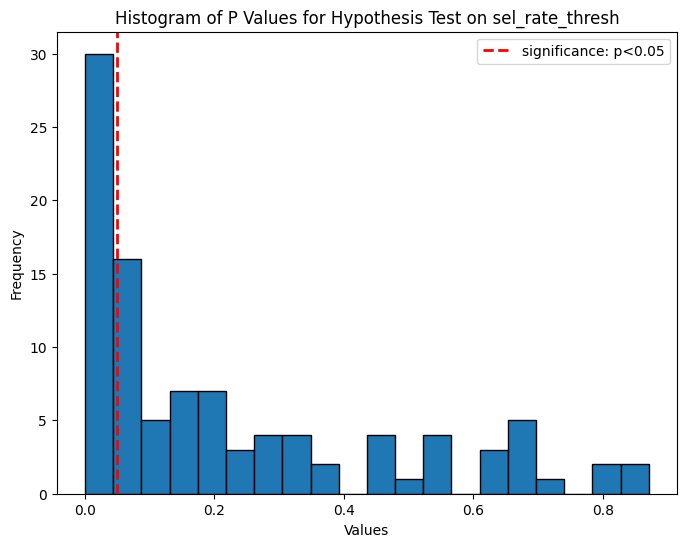

In [7]:
plot_p_values(audit_stats)